In [1]:
import numpy as np
import time
from collections import deque
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import copy

+--------------+--------------------+------------+-----------------+--------+
|  Algorithm   | Execution Time (s) | Iterations | Recursive Calls | Solved |
+--------------+--------------------+------------+-----------------+--------+
|     CSP      |       6.1202       |    307     |       308       |  Yes   |
| Backtracking |       0.7755       |    4208    |       4209      |  Yes   |
+--------------+--------------------+------------+-----------------+--------+


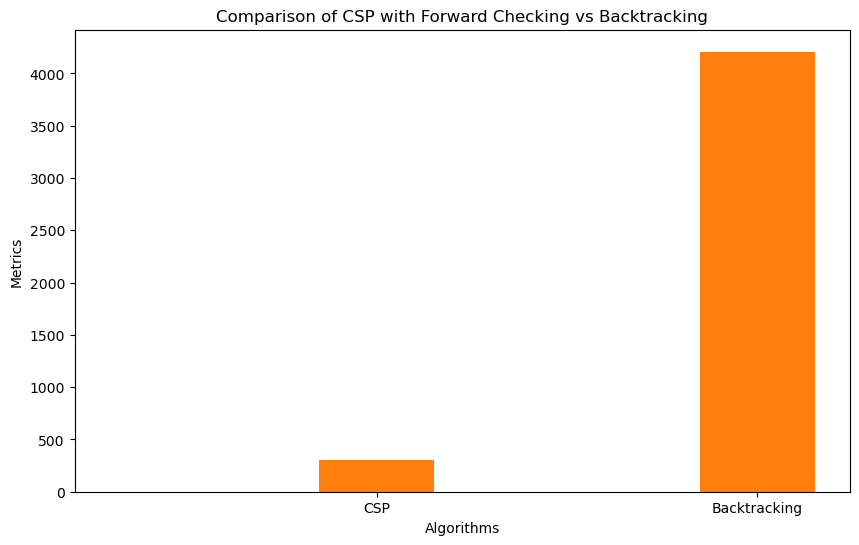

In [5]:
class SudokuSolver:
    def __init__(self, board, size=9):
        self.board = np.array(board)
        self.size = size
        self.subgrid_size = int(np.sqrt(self.size))
        self.iterations = 0
        self.recursive_calls = 0
        self.domains = {}

    def find_neighbors(self, row, col):
        """Get all neighbor cells in the same row, column, or subgrid."""
        neighbors = set()

        # Same row
        for c in range(self.size):
            if c != col:
                neighbors.add((row, c))

        # Same column
        for r in range(self.size):
            if r != row:
                neighbors.add((r, col))

        # Same subgrid
        start_row = (row // self.subgrid_size) * self.subgrid_size
        start_col = (col // self.subgrid_size) * self.subgrid_size
        for r in range(start_row, start_row + self.subgrid_size):
            for c in range(start_col, start_col + self.subgrid_size):
                if (r, c) != (row, col):
                    neighbors.add((r, c))

        return neighbors

    def ac3(self):
        """Optimized AC-3 algorithm to make the CSP arc-consistent."""
        queue = deque([(row, col) for row in range(self.size) for col in range(self.size) if self.board[row][col] == 0])

        while queue:
            row, col = queue.popleft()
            for neighbor in self.find_neighbors(row, col):
                if self.revise(row, col, neighbor):
                    if not self.domains[(row, col)]:
                        return False  # No valid assignment, failure
                    for n in self.find_neighbors(row, col):
                        if n != neighbor:
                            queue.append(n)  # Re-add affected neighbors to the queue
        return True

    def revise(self, row, col, neighbor):
        """Revise the domain of the variable (row, col) given the neighbor's domain."""
        revised = False
        to_remove = set()
        for value in self.domains[(row, col)]:
            if all(value == self.domains[n] for n in self.find_neighbors(row, col)):  # If no valid value exists
                to_remove.add(value)
        if to_remove:
            self.domains[(row, col)] -= to_remove
            revised = True
        return revised

    def forward_check(self):
        """Optimized forward checking."""
        for (row, col), domain in self.domains.items():
            if len(domain) == 1:
                value = next(iter(domain))
                for neighbor in self.find_neighbors(row, col):
                    if value in self.domains[neighbor]:
                        self.domains[neighbor].remove(value)  # Remove conflicting value from neighbor's domain

    def select_unassigned_variable(self):
        """Choose the unassigned variable with the smallest domain (MRV heuristic)."""
        unassigned = [(row, col) for row in range(self.size) for col in range(self.size) if len(self.domains[(row, col)]) > 1]
        return min(unassigned, key=lambda x: len(self.domains[x]), default=None)

    def is_solved(self):
        """Check if the CSP is solved (all variables have only one value in their domain)."""
        return all(len(self.domains[(row, col)]) == 1 for row in range(self.size) for col in range(self.size))

    def backtrack_csp(self):
        """Recursive backtracking with forward checking and AC-3 for CSP."""
        self.recursive_calls += 1
        if self.is_solved():
            return True

        var = self.select_unassigned_variable()
        if not var:
            return False

        row, col = var
        for value in sorted(self.domains[(row, col)]):
            local_domains = copy.deepcopy(self.domains)  # Save current state to backtrack if necessary
            self.domains[(row, col)] = {value}

            self.forward_check()  # Apply forward checking before recursion

            self.iterations += 1  # Counting search iterations, not preprocessing iterations

            if self.ac3():
                if self.backtrack_csp():
                    return True

            self.domains = local_domains  # Restore domains if failure

        return False

    def solve_csp(self):
        """Solve the Sudoku using CSP with AC-3, Forward Checking, and Backtracking."""
        # Initialize domains for all variables
        self.domains = {
            (row, col): {self.board[row][col]} if self.board[row][col] != 0 else set(range(1, self.size + 1))
            for row in range(self.size)
            for col in range(self.size)
        }

        # Apply AC-3 to make the initial board arc-consistent, do not count iterations here
        self.ac3()

        # Apply backtracking to solve the Sudoku
        if not self.backtrack_csp():
            return False

        # Assign final values to the board
        for (row, col), values in self.domains.items():
            if len(values) == 1:
                self.board[row][col] = next(iter(values))

        return True

    def solve_using_backtracking(self):
        """Solve the Sudoku using standard backtracking."""
        def is_solved():
            """Check if the board is fully assigned."""
            return not any(0 in row for row in self.board)

        def select_unassigned_variable():
            """Selection of next variable assignment, prioritizing empty cells."""
            for r in range(self.size):
                for c in range(self.size):
                    if self.board[r, c] == 0:
                        return r, c
            return None

        def is_valid_assignment(row, col, value):
            """Check if the value can be assigned to the cell."""
            # Check row, column, and subgrid
            if value in self.board[row] or value in self.board[:, col]:
                return False
            subgrid_row = (row // self.subgrid_size) * self.subgrid_size
            subgrid_col = (col // self.subgrid_size) * self.subgrid_size
            if value in self.board[subgrid_row:subgrid_row + self.subgrid_size, subgrid_col:subgrid_col + self.subgrid_size]:
                return False
            return True

        def backtrack():
            """Recursive backtracking."""
            self.recursive_calls += 1  # Count each recursive call
            if is_solved():
                return True

            row, col = select_unassigned_variable()
            if row is None:
                return False

            for value in range(1, self.size + 1):
                if is_valid_assignment(row, col, value):
                    self.board[row, col] = value
                    self.iterations += 1  # Count each assignment to a cell
                    if backtrack():
                        return True
                    self.board[row, col] = 0

            return False

        start_time = time.time()
        result = backtrack()
        end_time = time.time()

        execution_time = end_time - start_time  # Store execution time for backtracking

        return result, execution_time

def solve_using_metrics(algorithm, board):
    """Solve Sudoku board with specified algorithm and collect metrics."""
    solver = SudokuSolver(board)
    start_time = time.time()

    if algorithm == "CSP":
        solved = solver.solve_csp()
        end_time = time.time()
    else:
        solved, execution_time = solver.solve_using_backtracking()
        end_time = time.time()

    return {
        "Algorithm": algorithm,
        "Execution Time (s)": round(end_time - start_time, 4),
        "Iterations": solver.iterations,
        "Recursive Calls": solver.recursive_calls,
        "Solved": "Yes" if solved else "No"
    }

def plot_results(metrics_list):
    """Plotting the results in bar graph."""
    algorithms = [metrics["Algorithm"] for metrics in metrics_list]
    execution_times = [metrics["Execution Time (s)"] for metrics in metrics_list]
    iterations = [metrics["Iterations"] for metrics in metrics_list]

    # Bar chart for Execution Time and Iterations
    x = np.arange(len(algorithms))
    width = 0.3

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Plot for Execution Time and Iterations Graph
    ax.bar(x - width, width, label="Execution Time (s)")
    ax.bar(x, iterations, width, label="Iterations")
    ax.set_xlabel("Algorithms")
    ax.set_ylabel("Metrics")
    ax.set_title("Comparison of CSP with Forward Checking vs Backtracking")
    ax.set_xticks(x)
    ax.set_xticklabels(algorithms)
    
    
    
    plt.show()

if __name__ == "__main__":
    # Example Sudoku boards for testing
    board_1 = [
        [5, 3, 0, 0, 7, 0, 0, 0, 0],
        [6, 0, 0, 1, 9, 5, 0, 0, 0],
        [0, 9, 8, 0, 0, 0, 0, 6, 0],
        [8, 0, 0, 0, 6, 0, 0, 0, 3],
        [4, 0, 0, 8, 0, 3, 0, 0, 1],
        [7, 0, 0, 0, 2, 0, 0, 0, 6],
        [0, 6, 0, 0, 0, 0, 2, 8, 0],
        [0, 0, 0, 4, 1, 9, 0, 0, 5],
        [0, 0, 0, 0, 8, 0, 0, 7, 9]
    ]

    # Run tests for both algorithms
    results = []
    results.append(solve_using_metrics("CSP", board_1))
    results.append(solve_using_metrics("Backtracking", board_1))

    # Print results as a table
    table = PrettyTable()
    table.field_names = ["Algorithm", "Execution Time (s)", "Iterations", "Recursive Calls", "Solved"]
    for result in results:
        table.add_row([result["Algorithm"], result["Execution Time (s)"], result["Iterations"], result["Recursive Calls"], result["Solved"]])

    print(table)
    plot_results(results)
